# Advanced Circuits

In this lesson, we move beyond single-gate demonstrations and start building small but meaningful quantum circuits. Our goal is to show how quantum gates can be composed to perform a concrete computational task — in this case, a quantum half adder.

At the same time, we introduce a crucial idea that becomes unavoidable as circuits grow more complex: real quantum hardware is constrained. Unlike simulators, real devices:

* only support certain gate sets,

* have limited qubit connectivity,

* and are affected by noise.

To bridge the gap between the ideal circuit we design and the physical circuit that can actually run on hardware, we introduce transpilation.

By the end of this lesson, students will:

* understand how to construct a multi-qubit circuit that performs a useful logical task,

* see how a high-level circuit is transformed to respect hardware limitations,

* and understand why this transformation step is necessary in practice.

# 1. Quantum Half Adder

Classically, a half adder computes:

* Sum = A ⊕ B

* Carry = A AND B

The quantum half adder mirrors this structure using:

* CNOT gates to compute XOR (sum),

* Toffoli (CCX) gates to compute AND (carry).

| Qubit | Purpose         |
| ----- | --------------- |
| 0     | Input A         |
| 1     | Input B         |
| 2     | Sum = A XOR B   |
| 3     | Carry = A AND B |


The classical adder circuit uses an XOR and an AND gate to calculate the sum and carry bits, respectively. We can adapt these gates to the quantum context to make the quantum half adder. First, remembering that quantum gates are reversible, we cannot simply overwrite the inputs. Instead, we introduce two helper qubits initialized to ∣0⟩ to store the sum and carry outputs. So, our full quantum state will consist of qubits A and B, and the sum and carry qubits, which we'll label S and C:

$\ket{\psi} = \ket{ABSC}$

Now, we need quantum gates that accomplish what the XOR and AND gates did in the classical circuit.

## Sum:

For the XOR, we apply two CNOTs, each with control qubits A and B and target qubit S for both. If A and B are different, then one of the CNOT gates will flip S to the $\ket{1}$ state. If A and B are both $\ket{0}$ then nothing happens to S and it remains in the $\ket{0}$ state. If A and B are both $\ket{1}$, then the state of S will flip twice bringing it back to the $\ket{0}$ state.

## Carry:

For the carry bit, we need something that works like the classical AND gate. For this we introduce our first 3 qubit gate, the CCNOT gate, also known as the Toffoli gate.

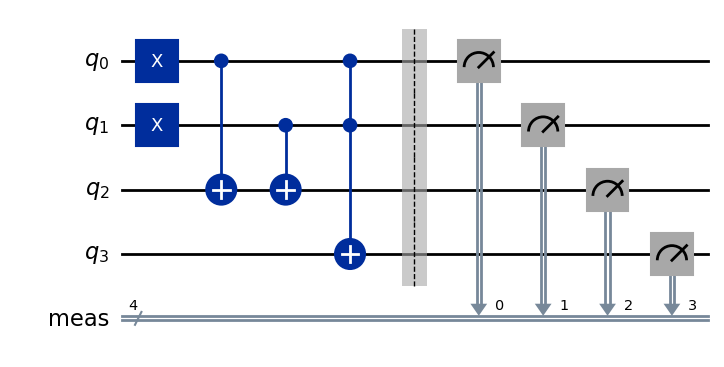

In [150]:
from qiskit import QuantumCircuit

# qubits: a, b, sum, carry
half_adder_circuit = QuantumCircuit(4)
 
# Choose values for A and B:
a = 1
b = 1
 
# Prepare A and B qubits according to selected values:
if a:
    half_adder_circuit.x(0)
if b:
    half_adder_circuit.x(1)
 
# XOR (sum) into qubit 2
half_adder_circuit.cx(0, 2)
half_adder_circuit.cx(1, 2)
 
# AND (carry) into qubit 3
half_adder_circuit.ccx(0, 1, 3)  # a AND b
 
# measure
half_adder_circuit.measure_all() 
# By default measure_all() adds classical bits to a classical register to store measurement
 
half_adder_circuit.draw("mpl")

# 2. Optimizing for Hardware

Now that we have mapped our problem onto a quantum circuit, we should be ready to go right? Not quite. We now need to map our high level quantum circuit onto a hardware backend. The circuit we have prepared above is known as the circuit representation on the **logical level** where: 

* gates are fully connected

* any gate can be applied anwhere 

* gates are assumed to be perfect

However in practice real hardware has:

* limited connectivity (for example what if qubit 0 and qubit 3 aren't connected?)

* restricted native gate sets (gates must be decomposed)

* specific qubit layouts and control electronics

### Let's address the limited connectivity problem for example. What do we do if we need qubit 0 and qubit 3 to talk to each other but out backend only allows for nearest neighbour interactions?



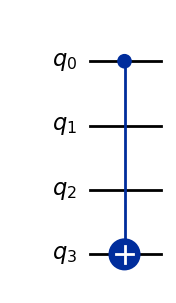

In [41]:
qc = QuantumCircuit(4)

qc.cx(0, 3)

qc.draw(output='mpl')

## One way of accomplishing this could be to use SWAP gates

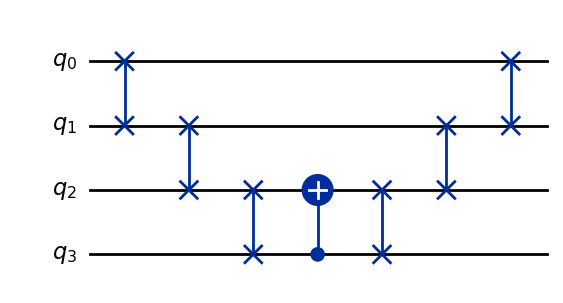

In [43]:
qc = QuantumCircuit(4)

# Move qubit 0 next to qubit 3 using SWAPs
qc.swap(0, 1)
qc.swap(1, 2)
qc.swap(2, 3)

# Now qubit 0 is effectively at position 3
# Apply CX (now local, but at huge cost)
qc.cx(3, 2)  # control = original qubit 0, target = original qubit 3

# Swap everything back
qc.swap(2, 3)
qc.swap(1, 2)
qc.swap(0, 1)

qc.draw("mpl")

## And if our hardware backend doesn't support SWAP gates?

### It turns out the SWAP gate is equivalent to applying CNOT gates alternating the target and control qubit

dict_keys(['rz', 'switch_case', 'reset', 'if_else', 'for_loop', 'delay', 'cx', 'id', 'measure', 'x', 'sx'])


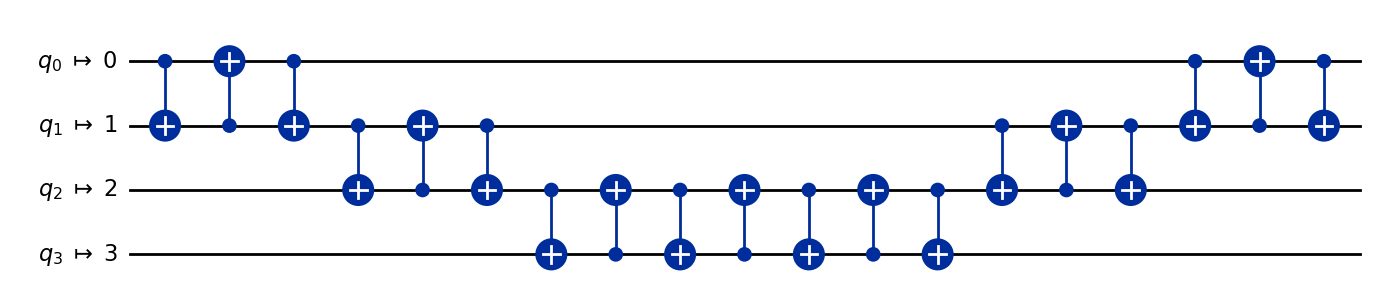

In [115]:
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

fake_backend = FakeManilaV2()
 
target = fake_backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=0)
qc_isa = pm.run(qc)
 

print(target.operation_names)
qc_isa.draw("mpl")

## `pass_managers` expose some of the transpilation steps and allow customization. However, you can also just use the `transpile` function.

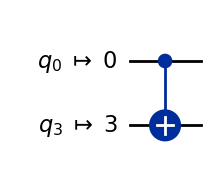

In [ ]:
from qiskit import transpile

qc_transpiled = transpile(qc)
qc_transpiled.draw(output='mpl')

## Let's transpile our quantum hald adder from before

transpiled circuit depth = 27


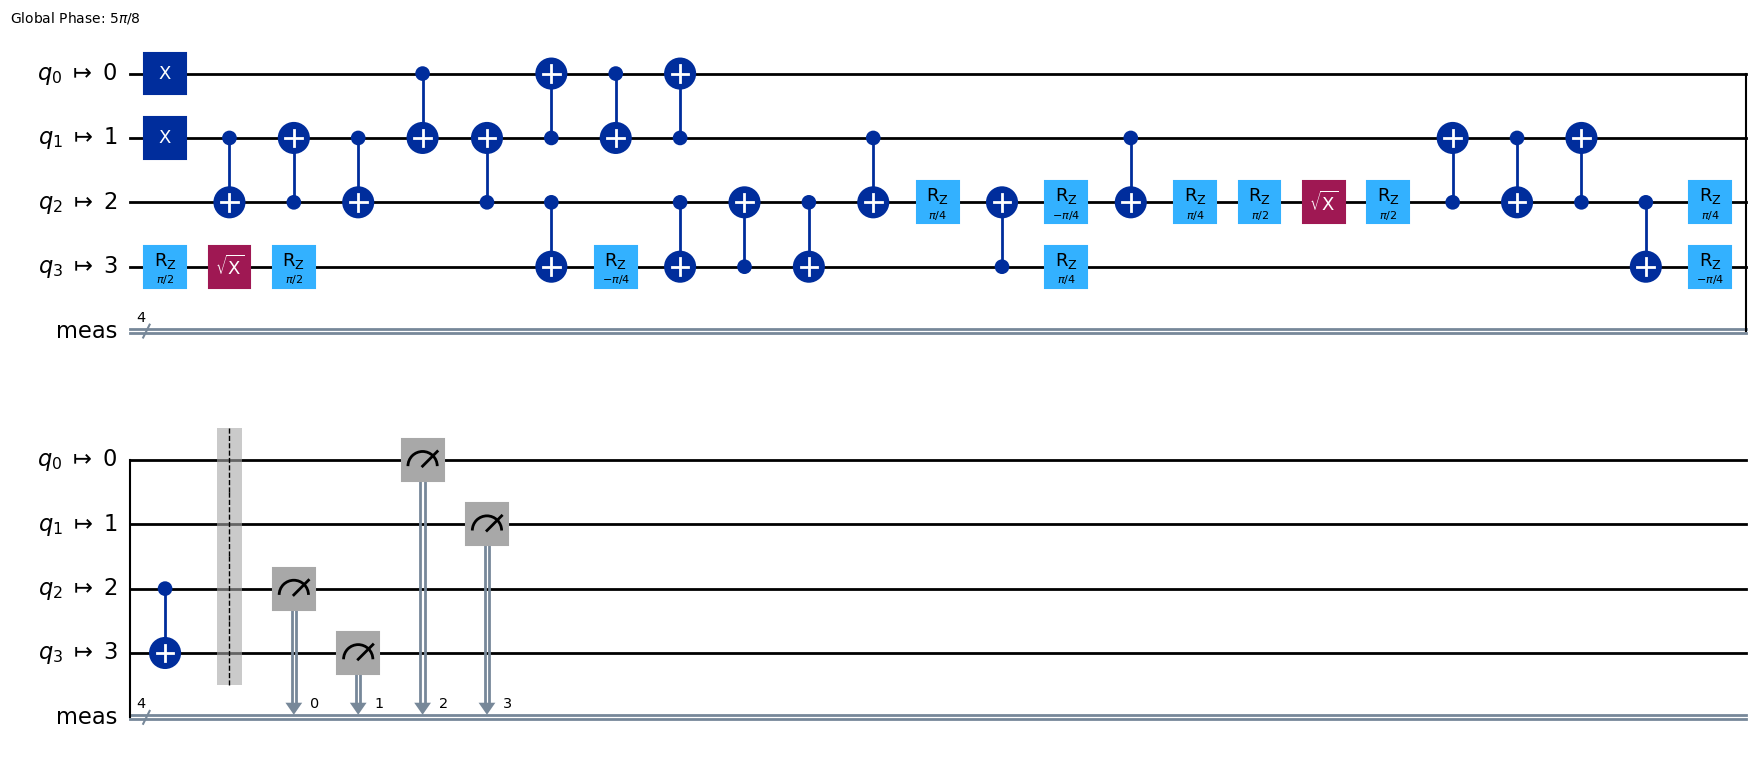

In [151]:
fake_backend = FakeManilaV2()
 
target = fake_backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=0)
qc_isa = pm.run(half_adder_circuit)
 
print(f"transpiled circuit depth = {qc_isa.depth()}")
qc_isa.draw("mpl")

# Sampler

### A "Sampler" is a primitive designed to sample possible states resulting from a quantum circuit, and collect statistics on what states might be measured and with what probability. We import the Qiskit Runtime Sampler here:

counts =  {'1011': 1024}


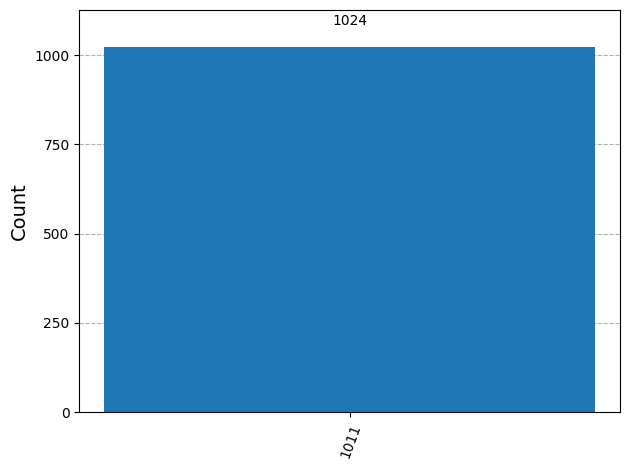

In [152]:
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit.primitives import BackendSamplerV2 as Sampler
from qiskit.visualization import plot_histogram
 
noise_model = NoiseModel.from_backend(fake_backend)
 
# Define a simulator using Aer, and use it in Sampler.
backend_sim = AerSimulator(noise_model=None)
sampler_sim = Sampler(backend=backend_sim)

job = sampler_sim.run([qc_isa], shots=1024)
result = job.result()
counts = result[0].data.meas.get_counts()

print("counts = ", counts)
plot_histogram(counts)

# Estimator

In [ ]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit
from qiskit.quantum_info import Pauli
import numpy as np

# 1) Build your half‑adder circuit
qc = QuantumCircuit(4)
a = 1
b = 0

if a:
    qc.x(0)  # A=1
if b:
    qc.x(1)  # B=1
qc.cx(0, 2)
qc.cx(1, 2)
qc.ccx(0, 1, 3)

# 2) Define the observables in modern Pauli letter form
#    'I' = identity, 'Z' = Z operator
#    Order: qubit 3, qubit 2, qubit 1, qubit 0 (big‑endian string)
observable_sum = Pauli("IZII")   # measure Z on qubit 2 (Sum)
observable_carry = Pauli("ZIII") # measure Z on qubit 3 (Carry)

# 3) Set up the backend and Estimator
noise_model = NoiseModel.from_backend(fake_backend)
backend_sim = AerSimulator(noise_model=noise_model)
estimator = Estimator(mode=backend_sim)

# 4) Create a PUB for Estimator: (circuit, [observables])
pub = (qc, [observable_sum, observable_carry])

# 5) Submit the Estimator job
job = estimator.run([pub])  
result = job.result()

# 6) Get expectation values
exp_values = result[0].data.evs  # list of ⟨Z⟩ for each observable

# 7) Convert from ⟨Z⟩ in [-1,1] → probability in [0,1]
prob_sum = (1 - exp_values[0]) / 2
prob_carry = (1 - exp_values[1]) / 2

print(f"Expected ⟨Z⟩ for Sum    = {exp_values[0]:.3f}, probability = {prob_sum:.3f}")
print(f"Expected ⟨Z⟩ for Carry  = {exp_values[1]:.3f}, probability = {prob_carry:.3f}")

Expected ⟨Z⟩ for Sum    = -0.792, probability = 0.896
Expected ⟨Z⟩ for Carry  = 0.966, probability = 0.017
